In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install lightgbm
import lightgbm as lgb

from sklearn.model_selection import KFold, GroupKFold, TimeSeriesSplit, StratifiedKFold #only classification
from sklearn.metrics import roc_auc_score, mean_squared_error

import time

import os

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ssub = pd.read_csv('sample_submission.csv')

In [35]:
train.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


In [36]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [37]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [0]:
test.date = pd.to_datetime(test.date)
train.date = pd.to_datetime(train.date)

In [39]:
train.shape

(913000, 4)

In [0]:
#train[train.columns[train.dtypes=='float']].describe()

In [0]:
#train[train.columns[train.dtypes=='int64']].describe()

In [42]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df['sales'], [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

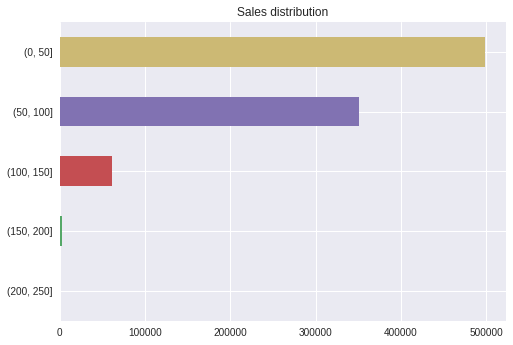

In [43]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
#sns.countplot(sales_count)

In [0]:
for df in train, test:
  df['dayofmonth'] = df.date.dt.day
  df['dayofyear'] = df.date.dt.dayofyear
  df['dayofweek'] = df.date.dt.dayofweek
  df['month'] = df.date.dt.month
  df['year'] = df.date.dt.year
  df['weekofyear'] = df.date.dt.weekofyear
  df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
  df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
  df.head()

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 12 columns):
date              913000 non-null datetime64[ns]
store             913000 non-null int64
item              913000 non-null int64
sales             913000 non-null int64
dayofmonth        913000 non-null int64
dayofyear         913000 non-null int64
dayofweek         913000 non-null int64
month             913000 non-null int64
year              913000 non-null int64
weekofyear        913000 non-null int64
is_month_start    913000 non-null int64
is_month_end      913000 non-null int64
dtypes: datetime64[ns](1), int64(11)
memory usage: 83.6 MB


In [46]:
target = 'sales'

excluded_features = [
    'date', 'sales' #, 'store', 'item'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features)
]
categorical_features

['store',
 'item',
 'dayofmonth',
 'dayofyear',
 'dayofweek',
 'month',
 'year',
 'weekofyear',
 'is_month_start',
 'is_month_end']

In [0]:
y_reg = np.log1p(train.sales)

train.drop(['sales'], axis=1, inplace=True)

In [0]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [0]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 31,  # 63, 127, 255
    'feature_fraction': 0.8, # 0.1, 0.01
    'bagging_fraction': 0.8,
    'learning_rate': 0.01, #0.00625,#125,#0.025,#05,
    'verbose': 1
}

In [51]:
folds = KFold(n_splits=5, shuffle=True, random_state=345665)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

i=0

for trn_, val_ in folds.split(train, y_reg):

    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.1,
        n_estimators=1500,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = i
    importances = pd.concat([importances, imp_df], axis=0)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.get_n_splits()
    
    i+=1
  

mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['store', 'item', 'dayofmonth', 'dayofyear', 'dayofweek', 'month', 'year', 'weekofyear', 'is_month_start', 'is_month_end']
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.0395362	valid_0's l2: 0.00156311
[200]	valid_0's rmse: 0.0378006	valid_0's l2: 0.00142889
[300]	valid_0's rmse: 0.0376113	valid_0's l2: 0.00141461
[400]	valid_0's rmse: 0.0375607	valid_0's l2: 0.00141081
[500]	valid_0's rmse: 0.0375238	valid_0's l2: 0.00140803
[600]	valid_0's rmse: 0.0374955	valid_0's l2: 0.00140591
[700]	valid_0's rmse: 0.0374876	valid_0's l2: 0.00140532
[800]	valid_0's rmse: 0.0374769	valid_0's l2: 0.00140452
Early stopping, best iteration is:
[777]	valid_0's rmse: 0.0374753	valid_0's l2: 0.0014044
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.0397396	valid_0's l2: 0.00157923
[200]	valid_0's rmse: 0.0378688	valid_0's l2: 0.00143404
[300]	valid_0's rmse: 0.0376842	valid_0's l2: 0.0014201
[400]	valid_0's rmse: 0.0376115	vali

0.03742719156065345

In [0]:
y_target = np.array(Y_target)

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = Y_target.mean(axis=0)
sub.to_csv('sub_lgb_baseline.csv', index=False)